<h1 id ="1" style="color:#03499A; border-radius: 4px; border: 3px solid #03499A; background-color: #ffffff; padding: 5px"><b><img src="Hochschule_Mannheim_logo.png" style="width: 150px">Lukas Fesenmeier, 1823570, Aminosäuren Datensatz</b></h1>
<p><i>Chemometric analysis of amino acid profiles for detection of fruit juice
adulterations – Application to verify authenticity of blood orange juice</i></p>
<h4>Struktur:</h4>
<ol>
    <li><a href="#1">Import</a></li>
    <li><a href="#2">Funktionen</a></li>
    <li><a href="#3">Frage 1</a></li>
    <li><a href="#4">Frage 2</a></li>
    <li><a href="#5">Frage 3</a></li>
    <li><a href="#6">Frage 4</a></li>
    <li><a href="#7">Bonusfrage</a></li>
    <li><a href="#8">Ausreißer</a></li>  
</ol>
<hr>
<h2>Import</h2>


In [1]:
#Importieren der Module 

#Basic
import numpy as np
import pandas as pd

#Visualisierungen
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


#Hilfsskripte wurden unter Funktionen in dieses Notebook kopiert, es gab keine Möglichkeit .py files per Mail zu verschicken...
#from confidence_ellipse import *
#from plotfunctions import *

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#Import der Daten
#Vorbereitung der unterschiedlichen Variablentypen
columns_types = {"Fruit Type": "category", "Juice Type": "category", "Production": "category", "Packaging": "category", "Condition": "category",
                "Sample ID": "object", }

#Einlesen der Excel Datei
ac_data = pd.read_excel("Amino acids.xlsx", header = 1, dtype = columns_types, index_col = "Sample ID")
display(ac_data.shape)
ac_data.head()

(217, 29)

,Fruit Type,Juice Type,Production,Packaging,Condition,Asp (mg/L),Thr (mg/L),Ser (mg/L),Asn (mg/L),Glu (mg/L),...,Leu (mg/L),Tyr (mg/L),Beta-Ala (mg/L),Phe (mg/L),GABA (mg/L),NH4 (mg/L),Orn (mg/L),Lys (mg/L),His (mg/L),Arg (mg/L)
Sample ID,,,,,,,,,,,,,,,,,,,,,
16-107136,sourcherry nectar,direct,conventional,carton pack,unfiltered,39.94,9.83,15.22,1070.30,25.64,...,5.99,25.83,0.0,7.48,86.91,71.05,0.0,2.44,4.62,7.96
16-108113,sourcherry nectar,concentrate,conventional,glass bottle,unfiltered,92.73,7.80,14.24,1051.60,32.49,...,3.50,4.61,0.0,2.62,47.12,73.78,0.0,2.16,4.49,6.59
16-110891,sourcherry nectar,unknown,conventional,glass bottle,unfiltered,30.25,6.21,7.97,740.78,17.68,...,1.92,3.84,0.0,2.92,61.58,61.41,0.0,0.00,4.37,3.86
16-111013,sourcherry nectar,unknown,conventional,glass bottle,unfiltered,87.11,6.74,10.00,922.76,40.88,...,2.75,4.29,0.0,1.46,57.49,81.14,0.0,2.99,5.52,4.06
16-114305,sourcherry nectar,direct,conventional,glass bottle,unfiltered,28.95,4.77,6.58,565.36,27.37,...,1.52,2.34,0.0,0.00,41.88,48.08,0.0,0.00,0.00,0.00


In [3]:
#fehlende Daten kontrollieren
ac_data.isna().sum().unique()

array([0], dtype=int64)

In [4]:
#Kontrollieren der Kategorien, auskommentiert aus Gründen der Übersicht

# for c in ac_data.loc[:,"Fruit Type":"Condition"].columns:
#     print(ac_data[c].value_counts())
#     print("\n")

<p>Erfolgreicher Import, der Datensatz ist <i>clean</i>, jede Reihe ist eine Observation und jede Spalte ist eine Variable, keine fehlenden Werte, keine Tippfehler in den Kategorien<p>


<a href = "#1">Link back to top</a>
<hr>
<h2 id="2">Benötigte Funktionen</h2>

In [5]:
def scree_plot(PCA):
    """
    In:
        PCA : sklearn.decomposition.PCA
            Fitted PCA object
    Out:
        fig : matplotlib.pyplot.figure object
            the scree plot object
    """

    expl_var_1 = PCA.explained_variance_ratio_

    with plt.style.context(('ggplot')):
        fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
        fig.set_tight_layout(True)
    
        ax1.plot(np.arange(1, len(expl_var_1) + 1, 1), expl_var_1,'-o', label="Explained Variance %")
        ax1.plot(np.arange(1, len(expl_var_1) + 1, 1), np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
        ax1.set_xlabel("PC number")
        ax1.set_ylabel("Explained Variance %")
        ax1.set_title('Scree plot')                
        plt.legend()
    return fig
    


def scores_plot(scores, y, PCs=(1,2)):
    """
    In:
        scores : np.array of shape (Nrows, Ncomp)
            scores matrix
        y : np.array of shape (Nrows,)
            vector of class labels; 
        PCs [optional] :  2-tuple of integers
            Principle Components to be plotted
    Out:
        fig : matplotlib.pyplot.figure object
            scores plot object
    """
    
    unique = np.unique(y) # list of unique labels
    colors = [plt.cm.jet(float(i)/len(unique)) for i in range(len(unique))]
    
    PCx = PCs[0]
    PCy = PCs[1]
    
    fig = plt.figure()

    with plt.style.context(('ggplot')):
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            xi = [scores[j,PCx-1] for j in range(len(scores[:,PCx-1])) if y[j] == u]
            yi = [scores[j,PCy-1] for j in range(len(scores[:,PCy-1])) if y[j] == u]
            plt.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))
    
        plt.xlabel('PC'+str(PCx))
        plt.ylabel('PC'+str(PCy))
        plt.legend(unique,loc='lower right')
        plt.title('Scores Plot')
        #plt.show()

    return fig


def loading_plot(loadings, dim, PCs=[1], xlabel='wave length [nm]'):
    """
    In:
        loadings : np.array of shape (Nrows, Ncomp)
            loadings matrix
        dim : numpy.ndarray of shape (n_features,)
            Wavelength, -number etc.
        PCs [optional] :  list of integers
            Principle Components to be plotted
    Out:
        fig : matplotlib.pyplot.figure object
            loadings plot object
    """

    fig = plt.figure()

    with plt.style.context(('ggplot')):
        for PC in PCs:
            plt.plot(dim, loadings[:,PC], label='PC'+str(PC))

    plt.xlabel(xlabel)
    plt.ylabel('Loading [a.u.]')
    plt.legend()

    return fig

def Tsq_Q_plot(X, scores, loadings, conf=0.95, title="T2_Q_Plot"):
    """
    T^2-Q-Plot of PCA results
    adapted from https://nirpyresearch.com/outliers-detection-pls-regression-nir-spectroscopy-python/ 
    
    In:
    X : np.array of shape (Nrows, Ncomp)
        data matrix
    scores : np.array of shape (Nrows, Ncomp)
        scores matrix
    loadings : np.array of shape (Nrows, Ncomp)
        loadings matrix
    conf [optional]: float
        confidence level

    Out:
        fig : matplotlib.pyplot.figure object
            T^2-Q plot object
    """

    ncomp = scores.shape[1]

    # residuals ("errors")
    Err = X - np.dot(scores,loadings.T)

    # Calculate Q-residuals (sum over the rows of the error array)
    Q = np.sum(Err**2, axis=1)

    # Calculate Hotelling's T-squared (note that data are normalised by default)
    Tsq = np.sum((scores/np.std(scores, axis=0))**2, axis=1)
    
    from scipy.stats import f
    # Calculate confidence level for T-squared from the ppf of the F distribution
    Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
                dfd=X.shape[0])*ncomp*(X.shape[0]-1)/(X.shape[0]-ncomp)

    # Estimate the confidence level for the Q-residuals
    i = np.max(Q)+1
    while 1-np.sum(Q>i)/np.sum(Q>0) > conf:
        i -= 1
    Q_conf = i

    fig = plt.figure()

    with plt.style.context(('ggplot')):
        fig = plt.plot(Tsq, Q, 'o')
    
        plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
        plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
        plt.xlabel("Hotelling's T-squared")
        plt.ylabel('Q residuals')
        plt.title(title)
    
    #plt.show()

    return fig, Q, Tsq

def confidence_ellipse_interv(x, y, ax, facecolor='none', conf_interv="90", **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Basic function from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    adapted by Lukas Fesenmeier with help of 
    https://www.cs.utah.edu/~tch/CS6640F2020/resources/How%20to%20draw%20a%20covariance%20error%20ellipse.pdf
    https://www.datasciencelearner.com/find-eigenvalues-eigenvectors-numpy/
    https://www.youtube.com/watch?v=0GzMcUy7ZI0
    https://www.youtube.com/watch?v=-8q-yKY-vg4&t=1082s

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    conf_interval : string
        The confidence interval wich is needed, avaiable in this function: '90', '95', '99'

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)

    #Values from Literatur: chi-square probability table; https://people.richland.edu/james/lecture/m170/tbl-chi.html
    # 2 Degrees of Freedom ("Freiheitsgrade")

    if conf_interv == "90":
        s = 4.605
    elif conf_interv == "95":
        s = 5.991
    elif conf_interv == "99":
        s = 9.210
    else:
        raise ValueError("must be string with value '90', '95' or '99', other values must be calculated individually or use other function")

    #get Eigenvalues and Eigenvectors
    evalues, evectors = np.linalg.eig(cov) 
    evalues = np.sqrt(evalues)


    #Ellipsengleichung
    ellipse = Ellipse(xy = (np.mean(x), np.mean(y)), 
    width = evalues[0]*np.sqrt(s) *2, height = evalues[1]* np.sqrt(s)* 2,
    angle = np.rad2deg(np.arccos((evectors[0,0]))), alpha = 0.3, facecolor=facecolor, **kwargs)

    return ax.add_patch(ellipse)

#Confidence Ellipse from Matplotlib, using std
def confidence_ellipse_std(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Function from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

<a href = "#1">Link back to top</a>
<hr>
<h2 id="3">Frage 1</h2>
<p><i>1.	Stellen Sie die Haupterkenntnis aus der PCA von Nietner et al. in einem Jupyter-Notebook dar.
Wie verändert sich die Aussage, wenn Sie das Konfidenzintervall auf 99% anheben?</i></p>

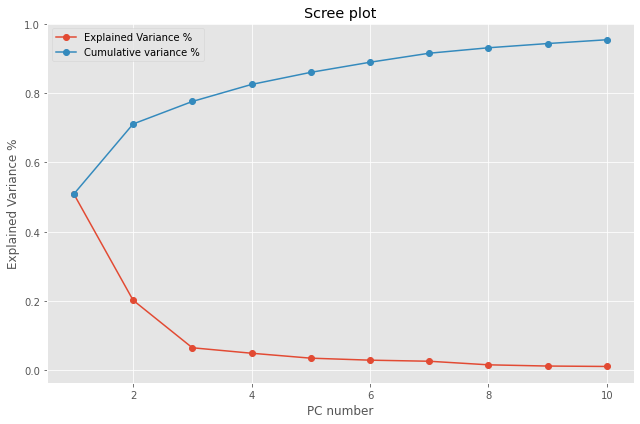

In [6]:
X = ac_data.loc[:, "Asp (mg/L)":].values
Y = ac_data.loc[:, "Fruit Type"].values

#mean center and scale each variable to unit standard deviation, Nieter et al
X_scaled = StandardScaler().fit_transform(X)


#ScreePlot
pca_Scree = PCA(n_components=10).fit(X_scaled)
scree_plot(pca_Scree)

#get explained Variance for AxesLabel, needed later
pc1_var , pc2_var = (pca_Scree.explained_variance_ratio_[0:2]*100).round(decimals = 2)  # * 100 für Prozent, round() on two decimals
pc1_label = "PC1 (" + str(pc1_var) + "%)"
pc2_label = "PC2 (" + str(pc2_var) + "%)"

In [7]:
#PCA durchführen
pca = PCA(n_components=4).fit(X_scaled)
scores = pca.transform(X_scaled)
loadings = pca.components_.T
scores_matrix = pd.DataFrame(data = scores, columns = ["PC1", "PC2", "PC3", "PC4"])
scores_matrix

# Scores_matrix mit Kategorien zusammenführen
scores_matrix.index = ac_data.index
    #scores_matrix_Version1 = pd.concat([scores_matrix, ac_data[["Fruit Type"]]], axis = 1)
scores_matrix["Fruit Type"] = Y
display(scores_matrix.head())

#Loadings_matrix 
loadings_matrix = pd.DataFrame(data = loadings, columns = ["PC1", "PC2", "PC3", "PC4"], index = ac_data.loc[:,"Asp (mg/L)":].columns)
loadings_matrix.head()

,PC1,PC2,PC3,PC4,Fruit Type
Sample ID,,,,,
16-107136,-3.495611,2.381502,3.382604,-0.238837,sourcherry nectar
16-108113,-4.375987,0.972648,3.051450,-0.280229,sourcherry nectar
16-110891,-5.033418,0.518366,2.244095,-0.166955,sourcherry nectar
16-111013,-4.554158,0.769312,3.489998,0.471132,sourcherry nectar
16-114305,-5.379043,0.069097,1.564567,0.605955,sourcherry nectar


,PC1,PC2,PC3,PC4
Asp (mg/L),0.206384,-0.250330,0.059862,-0.188614
Thr (mg/L),0.190375,0.163244,0.000841,0.076792
Ser (mg/L),0.268855,-0.123097,0.032295,-0.078929
Asn (mg/L),0.005250,0.084369,0.674489,-0.186477
Glu (mg/L),0.197751,-0.214324,-0.144136,0.166424


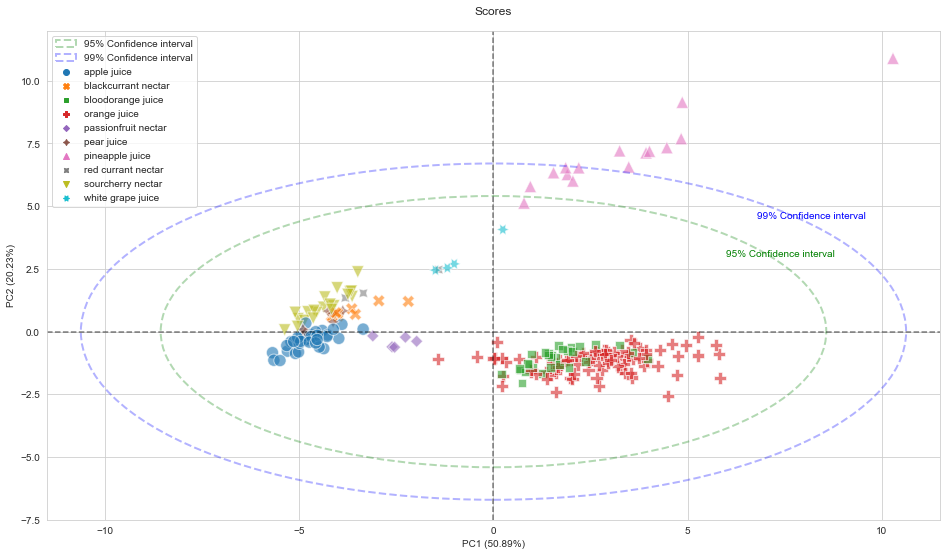

In [8]:
#ScoresPlot

#Voreinstellungen für den Plot
sns.set_style("whitegrid")
fig, ax0 = plt.subplots(figsize = (16, 9))

#Plotten der Scores Matrix
sns.scatterplot(data = scores_matrix, x = "PC1", y = "PC2", hue = "Fruit Type", style = "Fruit Type", ax = ax0, alpha = .6, s = 150)

#Axen Einstellungen
ax0.set_title("Scores", pad = 16)
ax0.axvline(x = 0, linestyle = "--", alpha = .5, color = "black")
ax0.axhline(y = 0, linestyle = "--", alpha = .5, color = "black")
ax0.set_xlim([-11.5, 11.5])
ax0.set_ylim([-7.5, 12])
ax0.set_xlabel(pc1_label)
ax0.set_ylabel(pc2_label)


#Konfidenz-Ellipsen, Funktion definiert in confidence_ellipse.py
confidence_ellipse_interv(x = scores_matrix["PC1"], y = scores_matrix["PC2"], conf_interv = "95", edgecolor = "green", ax = ax0, linestyle = "--",
label="95% Confidence interval", linewidth = 2)
ax0.annotate(text = "95% Confidence interval", xy = (6,3), color = "green")
confidence_ellipse_interv(x = scores_matrix["PC1"], y = scores_matrix["PC2"], conf_interv = "99", edgecolor = "blue", ax = ax0, linestyle = "--",
label= "99% Confidence interval", linewidth = 2)
ax0.annotate(text = "99% Confidence interval", xy = (6.8,4.5), color = "blue")
plt.legend()

plt.show()

<h3>Antwort</h3>
<p><u>Kernaussage:</u><br>Mithilfe einer multivariaten Datenanalyse (hier: PCA) können die Aminosäurenprofile verschieder Fruchtsäfte voneinander differenziert werden. Aufgrund der Ergebnissen dieser PCA (oben) wird empfohlen die Implementierung von multivariaten Datenanalysen in den Laboralltag voranzutreiben. Anstelle sich auf einzelne Aminosäuren zu fokussieren, kann mithilfe von multivariaten Methoden ein Einblick über gesamte Aminosäurenprofile gewonnen werden. Dieser Einblick über gesamte Aminosäurenprofile kann herangezogen werden, um Säfte geringer Qualität zu unterscheiden. Typische Methoden, welche sich nur auf einzelne Aminosäuren fokusieren würden hier scheitern, da diese Bestandteile auch industriell zugesetzt werden können. Neben der Unterscheidung verschiedener Fruchtsorten kann auch Blutorangensaft von Orangensaft differenziert werden.</p>
<br>
<p>Das Erhöhen des Konfidenzintervalles hat zur Folge, dass mehr Messwerte innerhalb des Modells vorliegen. Wie zu sehen in der Grafik oben variieren Ananassäften in ihren Aminosäureürofilen stark von den übrigen Säften ab und fallen somit aus dem Konfidenzintervall (von 95%) heraus. Das Erhöhen auf 99% hat zur Folge, dass 6 Ananassäfte mehr im Modell enthalten sind. Werden die Konfidenzintervalle auf die Säfte getrennt berechnet (zu sehen in der nächsten Zelle), kann anhand der eingezeichneten Ellypsen eine Vorstellung der Verteilung gewonnen werden. Deutlich zu erkennen ist, dass die Ellypse je nach Konfidenzintervall mehr Messwerte umfasst. Aus diesem Grund überschneiden sich die für die Orangensäfte eingezeichneten 99% Ellypsen und verfälschen  die optische Zuordnung zu dem jeweiligen PC1/PC2 Cluster. </p>

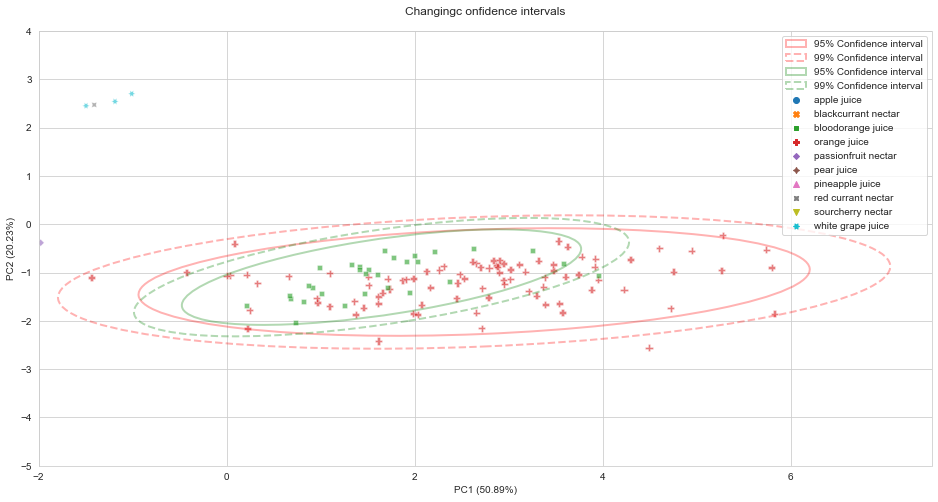

In [9]:
fig,ax0 = plt.subplots(figsize=(16,8))

#Plotten the Scores Matrix
sns.scatterplot(data = scores_matrix, x = "PC1", y = "PC2", hue = "Fruit Type", style = "Fruit Type", ax = ax0, alpha = .6, s = 50)

#Titel platzieren
ax0.set_title("Changingc onfidence intervals", pad = 16)

#Axen Einstellungen
    #Scores
ax0.set_xlim([-2, 7.5])
ax0.set_ylim([-5, 4])
    #Achsentitel
ax0.set_xlabel(pc1_label)
ax0.set_ylabel(pc2_label)


#Konfidenz-Ellipsen, Funktion definiert in confidence_ellipse.py
grouplist = ["orange juice", "bloodorange juice"]
colors = ["red", "green"]
for i, fruit in enumerate(grouplist):
    local_df = scores_matrix[scores_matrix["Fruit Type"] == fruit]
    confidence_ellipse_interv(local_df["PC1"], local_df["PC2"], ax = ax0, conf_interv="95", edgecolor= colors[i], linestyle= "-", label="95% Confidence interval", linewidth=2)
    confidence_ellipse_interv(local_df["PC1"], local_df["PC2"], ax = ax0, conf_interv="99", edgecolor= colors[i], linestyle= "--", label="99% Confidence interval", linewidth=2)
ax0.annotate("99% Confidence Ellypses", (-6,9.5), color = "black")
ax0.annotate("95% Confidence Ellypses", (-6,9), color = "blue")
plt.legend()
plt.show()

<hr>
<h2 id="4">Frage 2 </h2>
<p><i>2. Wie viele PCs benötigen Sie, um Orangensaft von Blutorangensaft zu differenzieren?</i></p>
<p>Zur Beantwortung dieser Frage wird zusätzlich zur obigen PCA mit allen Fruchtsäften eine weitere PCA mit <b>nur</b> Orangensäften durchgeführt. Beide PCA-Modelle werden durch Untersuchung der Varianz innerhalb einer zweidimensionalen Auftragung (der PCs mit der besten Auftrennung) untersucht.</p>

C:\Users\Win10\AppData\Local\Temp/ipykernel_10644/1957498728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orange_matrix1["Fruit Type"] = list(orange_matrix1["Fruit Type"]) #losing categorical data on purpose to reduce seaborn legend entries (convert series to list and back to series)


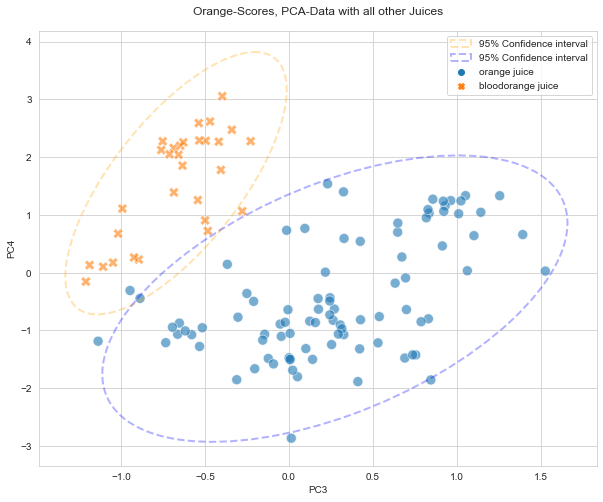

In [10]:
orange_matrix1 = scores_matrix[np.logical_or(scores_matrix["Fruit Type"] == "orange juice", scores_matrix["Fruit Type"] == "bloodorange juice")]
orange_matrix1["Fruit Type"] = list(orange_matrix1["Fruit Type"]) #losing categorical data on purpose to reduce seaborn legend entries (convert series to list and back to series)

orange_matrix1_onlybloodorange = orange_matrix1[orange_matrix1["Fruit Type"]== "bloodorange juice"]
orange_matrix1_no_bloodorange = orange_matrix1[orange_matrix1["Fruit Type"] != "bloodorange juice"]
fig, ax0 = plt.subplots(figsize = (10,8))

sns.scatterplot(data = orange_matrix1, x = "PC3", y = "PC4", hue = "Fruit Type", style = "Fruit Type", ax = ax0, alpha = .6, s = 100)
ax0.set_title("Orange-Scores, PCA-Data with all other Juices", pad = 16)

#Ellypsen
confidence_ellipse_interv(orange_matrix1_onlybloodorange["PC3"], y = orange_matrix1_onlybloodorange["PC4"], conf_interv = "95", edgecolor = "orange", ax = ax0, linestyle = "--",
label="95% Confidence interval", linewidth = 2)
confidence_ellipse_interv(orange_matrix1_no_bloodorange["PC3"], orange_matrix1_no_bloodorange["PC4"], conf_interv = "95", edgecolor = "blue", ax = ax0, linestyle = "--",
label= "95% Confidence interval", linewidth = 2)
plt.legend()



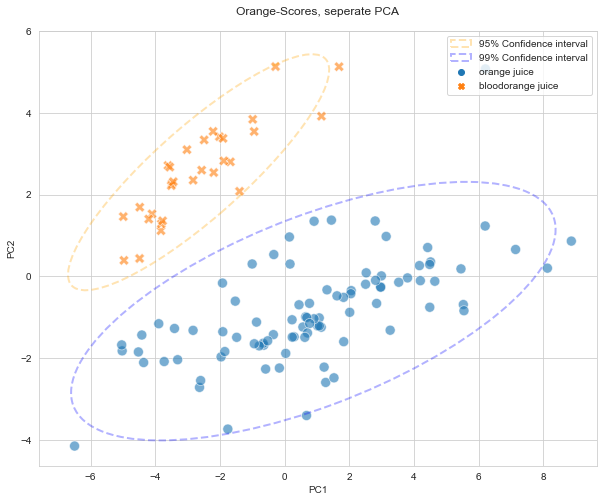

In [11]:
#Seperate PCA for OrangeJuices only
# Orangensäfte extrahieren
cat = ["orange juice", "bloodorange juice"]
orange_only = ac_data[ac_data["Fruit Type"].isin(cat)]

#New PCA für Orangensäfte
X_orange = orange_only.loc[:,"Asp (mg/L)":].values

#mean center and scale each variable to unit standard deviation, Nieter et al
X_orange_scaled = StandardScaler().fit_transform(X_orange)

#PCA durchführen
pca_orange = PCA(n_components=4).fit(X_orange_scaled)
scores_orange = pca_orange.transform(X_orange_scaled)

orange_matrix2 = pd.DataFrame(data = scores_orange, columns = ["PC1", "PC2", "PC3", "PC4"])

# Scores_matrix zusammenführen mit Kategorien
#losing categorical data on purpose to reduce seaborn legend entries (convert series to list and back to series)
orange_matrix2.index = orange_only.index
orange_matrix2["Fruit Type"] = list(orange_only["Fruit Type"])


#Loadings_matrix, braucht es novh nicht in diesem Kontext
loadings_orange = pca_orange.components_.T
loadings_matrix_orange = pd.DataFrame(data = loadings_orange, columns = ["PC1", "PC2", "PC3", "PC4"], index = orange_only.loc[:,"Asp (mg/L)":].columns)

orange_matrix2_onlybloodorange = orange_matrix2[orange_matrix1["Fruit Type"]== "bloodorange juice"]
orange_matrix2_no_bloodorange = orange_matrix2[orange_matrix1["Fruit Type"] != "bloodorange juice"]

fig, ax0 = plt.subplots(figsize=(10,8))

sns.scatterplot(data = orange_matrix2, x = "PC1", y = "PC2", hue = "Fruit Type", style = "Fruit Type", ax = ax0, alpha = .6, s = 100)
ax0.set_title("Orange-Scores, seperate PCA", pad = 16)

#Ellypsen
confidence_ellipse_interv(orange_matrix2_onlybloodorange["PC1"], orange_matrix2_onlybloodorange["PC2"], conf_interv = "95", edgecolor = "orange", ax = ax0, linestyle = "--",
label="95% Confidence interval", linewidth = 2)
confidence_ellipse_interv(orange_matrix2_no_bloodorange["PC1"], orange_matrix2_no_bloodorange["PC2"], conf_interv = "95", edgecolor = "blue", ax = ax0, linestyle = "--",
label= "99% Confidence interval", linewidth = 2)
plt.legend()


4.134400030740868

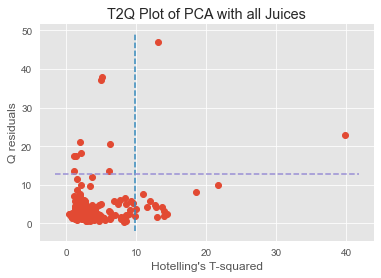

In [12]:
#Validation with T2Q
#T2Q-Plot mit k = 4
fig, Q, Tsq = Tsq_Q_plot(X_scaled, scores[:, :4], loadings[:,:4], conf=0.95, title= "T2Q Plot of PCA with all Juices")
np.std(Tsq)

1.8481545038127558

43

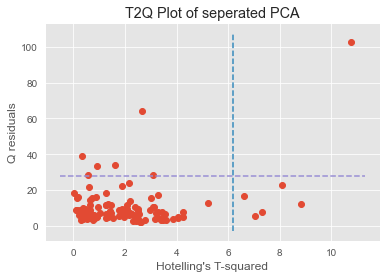

In [13]:
#T2Q-Plot mit k=2
fig2, Q_orange, Tsq_orange = Tsq_Q_plot(X_orange_scaled, scores_orange[:,:2], loadings_orange[:,:2], conf=0.95, title = "T2Q Plot of seperated PCA")
display(np.std(Tsq_orange))
np.argmax(Tsq_orange)

<h4>Antwort</h4>
<p>Die PCA, welche seperat für die Orangensäfte durchgeführt wurde, führt zu einer besseren Differenzierung. Zu sehen ist das an den Konfidenzellypsen, eigezeichnet in die beiden Scatterplots("Orange-Scores, PCA-Data with all other Juices" und "Orange-Scores, seperate PCA"). <br>Wird die PCA nicht seperat durchgeführt, dann kommt es bei Berücksichtigung von 95% der Werte bereits zu einer Überschneidung der Ellypsen. Bei der seperaten PCA ist das nicht der Fall. Die Auftrennung der Cluster ist visuell klarer deutlich. 
<br>Begründet wird das Ganze auch zusätzlich durch die jeweiligen T2Q-Plots. Im T2Q-Plot der separierten PCA ist die Varianz der T2-Werte und somit deren Standardabweichung wesentlich geringer als beim T2Q-Plot mit allen Säften. Das Modell mit der separierten PCA und den Hauptkomponenten PC1 und PC2 hat folglich die kleineren Residuen (Fehler) und ist besser geeignet den Datenraum zu beschreiben.
Es empfiehlt sich daher, die Orangensäfte getrennt zu behandeln, wenn diese im Fokus weiterer Datenanalysen liegen.
<br> Der Ausreißer mit Index 42 wird am Ende des Juiter Notebooks nächer betrachtet. Dieser kann mithilfe des Modells nicht erfasst werden, er hat sowohl einen hohen Q- als auch T2-Wert. </p>

<a href = "#1">Link back to top</a>
<hr>
<h2 id="5">Frage 3 </h2>
<p><i>3. Stellen Sie den Loadings-Plot dar. Kann man hiermit eine Aussage machen, welche Aminosäuren am meisten zur Differenzierung beitragen?</i></p>


No handles with labels found to put in legend.


(-0.5, 0.5)

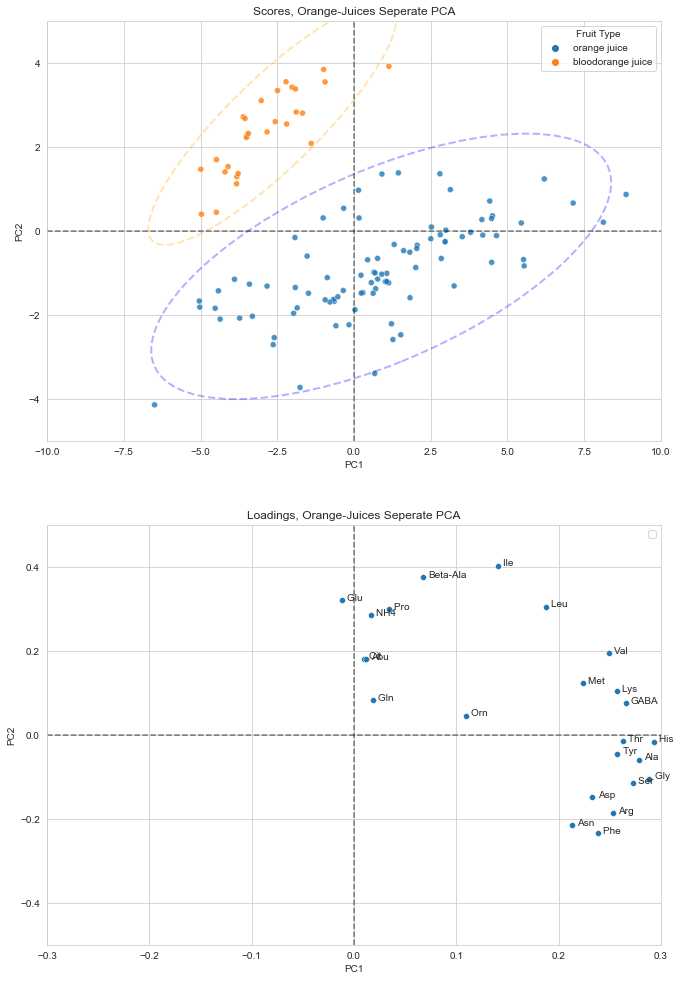

In [14]:
fig, (ax2, ax3) = plt.subplots(nrows = 2, ncols = 1, figsize = (11, 17))

#Plotten der Scores Matrix
sns.scatterplot(data = orange_matrix2, x = "PC1", y = "PC2", hue = "Fruit Type", ax = ax2, alpha = .8)
confidence_ellipse_interv(orange_matrix2_onlybloodorange["PC1"], orange_matrix2_onlybloodorange["PC2"], conf_interv = "95", edgecolor = "orange", ax = ax2, linestyle = "--",
label="95% Confidence interval", linewidth = 2)
confidence_ellipse_interv(orange_matrix2_no_bloodorange["PC1"], orange_matrix2_no_bloodorange["PC2"], conf_interv = "95", edgecolor = "blue", ax = ax2, linestyle = "--",
label= "99% Confidence interval", linewidth = 2)
plt.legend()


#Plotten der Loadings Matrix
sns.scatterplot(data = loadings_matrix_orange, x = "PC1", y = "PC2", ax = ax3)

#Annotieren der Loadings Matrix
for lab, row in loadings_matrix_orange.iterrows():
    if lab == "Beta-Ala (mg/L)": #solution to make sure not loosing Beta-Ala Annotation, but still getting rid of unit (mg/L)
        ax3.annotate(text = lab[:8], xy = (row[0] + 0.005,row[1]))
    else:
        ax3.annotate(text = lab[:4], xy = (row[0] + 0.005,row[1]))

#Einstellungen der Axen
    #Scores 

ax2.set_title("Scores, Orange-Juices Seperate PCA")
ax2.axvline(x = 0, linestyle = "--", alpha = .5, color = "black")
ax2.axhline(y = 0, linestyle = "--", alpha = .5, color = "black")
ax2.set_xlim([-10, 10])
ax2.set_ylim([-5, 5])

    #Loadings
ax3.set_title("Loadings, Orange-Juices Seperate PCA")
ax3.axvline(x = 0, linestyle = "--", alpha = .5, color = "black")
ax3.axhline(y = 0, linestyle = "--", alpha = .5, color = "black")
ax3.set_xlim([-0.3, 0.3])
ax3.set_ylim([-0.5, 0.5])

<p>Eine erste Betrachtung des LoadingsPlots liefert den Schluss, dass die Aminosäuren Asn, Phe, Asp, Arg im Wesentlichen zu Differenzierung beitragen. Diese Aminosäuren liegen im Loadingsplot entgegengesetzt zur Position der Blutorangen-Datenpunkte.</p>

In [15]:
# Idee: absolute Differenz der Mittelwerte aller Aminosäuren berechnen, 
# Um das Ganze auf die Varianz zu normen, wird der Standard Scaler verwendet
# Die Daten werden direkt nach dem Standard Scaler bezogen vor der PCA
test = pd.DataFrame(X_orange_scaled)
test.index = orange_only.index
test.columns = orange_only.columns[5:]
test["Fruit Type"] = orange_only["Fruit Type"]

ttt = test.groupby("Fruit Type").mean().round(decimals = 2) 
ttt = ttt.loc[["orange juice", "bloodorange juice"],:].transpose()
ttt["abs_scal_Dif"] = np.absolute(ttt["orange juice"] - ttt["bloodorange juice"]) 
ttt.sort_values("abs_scal_Dif", ascending = False).head()

Fruit Type,orange juice,bloodorange juice,abs_scal_Dif
Phe (mg/L),0.47,-1.40,1.87
Arg (mg/L),0.36,-1.09,1.45
Gly (mg/L),0.35,-1.06,1.41
Asn (mg/L),0.35,-1.05,1.40
Ser (mg/L),0.33,-0.98,1.31


Text(0.5, 1.0, "Einfluss auf die PC's, nur Orangensäfte")

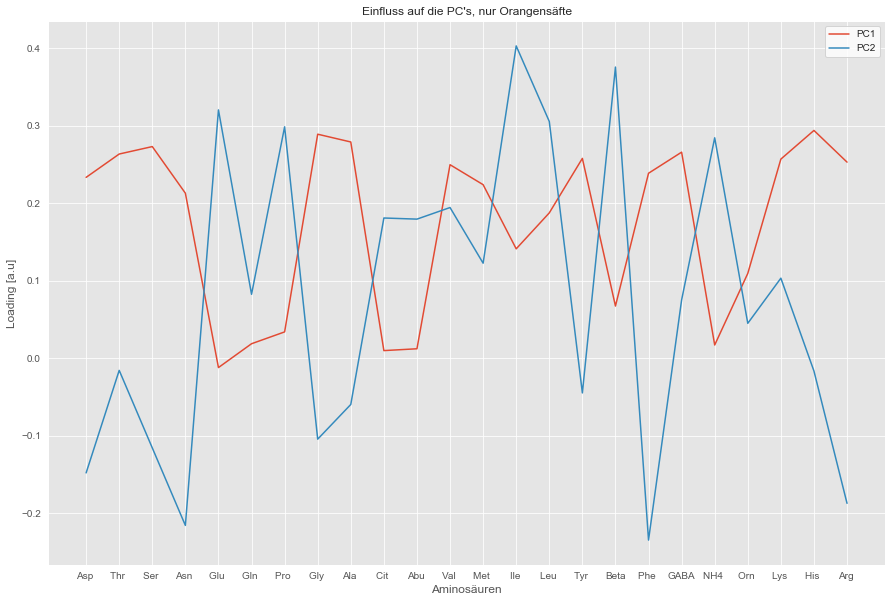

In [16]:
#Loadings Plot zur Verdeutlichung welche Aminosäuren auf welche PC Einfluss nehmen
x_loadings_matrix_orange_values= []
for item in loadings_matrix_orange.index:
    d = item[:4]
    x_loadings_matrix_orange_values.append(d)
x_loadings_matrix_orange_values

fig = plt.figure(figsize=(15,10))
with plt.style.context(("ggplot")):
    plt.plot(x_loadings_matrix_orange_values, loadings_matrix_orange["PC1"], label="PC1")
    plt.plot(x_loadings_matrix_orange_values, loadings_matrix_orange["PC2"], label="PC2")
plt.legend()
plt.xlabel("Aminosäuren")
plt.ylabel("Loading [a.u]")
plt.title("Einfluss auf die PC's, nur Orangensäfte")
#Einzeichnen der in der Tabelle berechneten Werte

<h4>Antowort</h4>
<p>Wie bereits im des ersten LoadingsPlot anhand der Positionen vermutet wurde, tragen die Aminosäuren Phe, Arg, Gly, Asn und Ser am meisten zur Differenzierung bei. Quantifiziert wurde das Ganze mit einer Tabellenkalkulation. In diese werden die standardskalierten Werte übertragen und dann geprüft inwiefern die genormten Mittelwerte voneinander abweichen. Schaut man sich im Diagramm "Einfluss auf die PC's" das genauer an, stellt man fest, dass diese 5 dadurch berechneten Aminosäuren den größten Einfluss auf die PCs 1 und 2 haben. Dies kann an den Minima und Maxima der beiden PC-Kurvenverläufen abgelesen werden.</p>

<a href = "#1">Link back to top</a>
<hr>
<h2 id = "6">Frage 4</h2>
<p><i>4. Eine Saftsorte trennt sich besonders vom Rest ab – welche? Und welche Aminosäure(n) bewirken dies?</i></p>
<p>Um diese Frage zu beantworten wird der Plot von der Frage1 zusammen mit dessen Loadingplots verwendet. Das Vorgehen bleibt dasselbe wie bei Frage 3.</p>


Text(0, 0.5, 'PC2 (20.23%)')

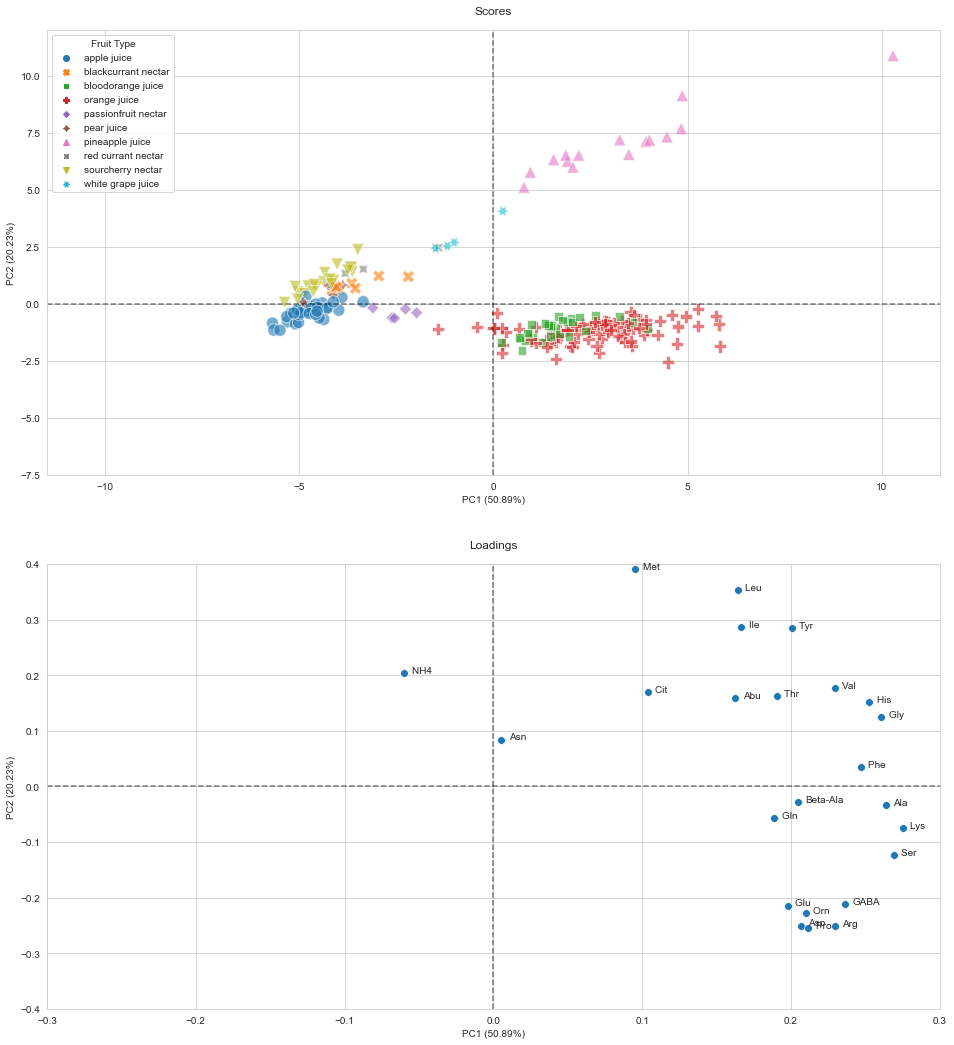

In [17]:
#ScoresPlot von Aufgabe1

#Voreinstellungen für den Plot

fig, (ax0, ax1) = plt.subplots(figsize = (16, 18), nrows = 2, ncols = 1)

#Plotten der Scores Matrix
sns.scatterplot(data = scores_matrix, x = "PC1", y = "PC2", hue = "Fruit Type", style = "Fruit Type", ax = ax0, alpha = .6, s = 150)

#Axen Einstellungen
ax0.set_title("Scores", pad = 16)
ax0.axvline(x = 0, linestyle = "--", alpha = .5, color = "black")
ax0.axhline(y = 0, linestyle = "--", alpha = .5, color = "black")
ax0.set_xlim([-11.5, 11.5])
ax0.set_ylim([-7.5, 12])
ax0.set_xlabel(pc1_label)
ax0.set_ylabel(pc2_label)

#Plotten the Loadings Matrix
sns.scatterplot(data = loadings_matrix, x = "PC1", y = "PC2", ax = ax1, s = 60)

#Annotieren der Loadings Matrix
for lab, row in loadings_matrix.iterrows():
    if lab == "Beta-Ala (mg/L)": #solution to make sure not loosing Beta-Ala Annotation, but still getting rid of unit (mg/L)
        ax1.annotate(text = lab[:8], xy = (row[0] + 0.005,row[1]))
    else:
        ax1.annotate(text = lab[:4], xy = (row[0] + 0.005,row[1]))

ax1.set_title("Loadings", pad = 16)
    #Loadings
ax1.axvline(x = 0, linestyle = "--", alpha = .5, color = "black")
ax1.axhline(y = 0, linestyle = "--", alpha = .5, color = "black")
ax1.set_xlim([-0.3, 0.3])
ax1.set_ylim([-0.4, 0.4])
    #Achsentitel
ax1.set_xlabel(pc1_label)
ax1.set_ylabel(pc2_label)

<p>Bereits auf dem ersten Blick hebt sich Anananassaft deutlich von den anderen Säften ab, wie im obigen Scatterplot zu erkennen. Grund hierfür ist der überdurchschnittlich hohe Gehalt an den folgenden Aminosäuren:
<ul>
    <li>Methionin, Met</li>
    <li>Leucin, Leu</li>
    <li>Isoleucin, Ile</li>
    <li>Tyrosin, Tyr</li>    
</ul>
Diese sind in diesem Loadingsplot klar oben rechts platziert.
</p>

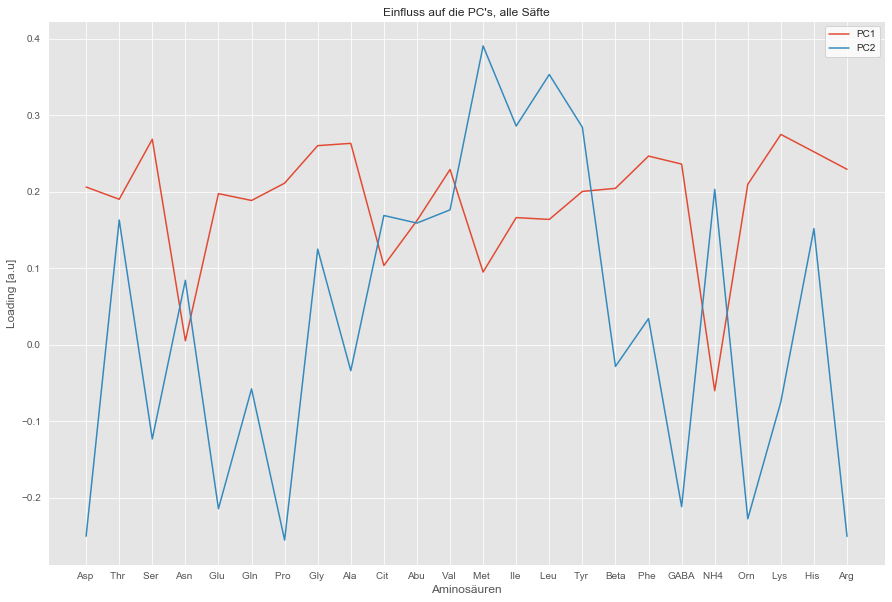

In [18]:
#Loadings Plot zur Verdeutlichung welche Aminosäuren auf welche PC Einfluss nehmen
x_loadings_matrix_values= []
for item in loadings_matrix_orange.index:
    d = item[:4]
    x_loadings_matrix_values.append(d)


fig = plt.figure(figsize=(15,10))
with plt.style.context(("ggplot")):
    plt.plot(x_loadings_matrix_values, loadings_matrix["PC1"], label="PC1")
    plt.plot(x_loadings_matrix_values, loadings_matrix["PC2"], label="PC2")
plt.legend()
plt.xlabel("Aminosäuren")
plt.ylabel("Loading [a.u]")
plt.title("Einfluss auf die PC's, alle Säfte")
plt.show()


In [19]:
# Idee: absolute Differenz der Mittelwerte aller Aminosäuren berechnen, 
# Um das Ganze auf die Varianz zu normen, wird der Standard Scaler verwendet
# Die Daten werden direkt nach dem Standard Scaler bezogen vor der PCA
test_alldata = pd.DataFrame(X_scaled)
test_alldata.index = ac_data.index
test_alldata.columns = ac_data.columns[5:]
test_alldata["Fruit Type"] = ac_data["Fruit Type"]

cond = pd.Series(test_alldata["Fruit Type"]=="pineapple juice")
pine_or_not = []
for lab, row in test_alldata.iterrows():
    if row["Fruit Type"] == "pineapple juice":
        pine_or_not.append("pineapple")
    else:
        pine_or_not.append("NON-pineapple")
test_alldata["pineapple_or_not"] = pine_or_not
test_alldata
ddd = test_alldata.groupby("pineapple_or_not").mean().round(decimals = 2) 
ddd = ddd.loc[["NON-pineapple", "pineapple"],:].transpose()
ddd["abs_scal_Dif"] = np.absolute(ddd["NON-pineapple"] - ddd["pineapple"]) 
ddd.sort_values("abs_scal_Dif", ascending = False).head()


pineapple_or_not,NON-pineapple,pineapple,abs_scal_Dif
Met (mg/L),-0.27,3.58,3.85
Leu (mg/L),-0.24,3.22,3.46
Tyr (mg/L),-0.21,2.81,3.02
Ile (mg/L),-0.18,2.48,2.66
His (mg/L),-0.15,1.99,2.14


<p>Die Ananassäfte haben verglichen mit den anderen Säften einen sehr viel höheren Gehalt an Met, Leu, Tyr, Ile und His. Wie im Loadingsplot "Einfluss auf die PC's" zu sehen, haben diese Aminosäuren signifikanten Einfluss auf die zweite principal Component. Aus diesem Grund haben die Anannassäfte in der zweidimensionalen Score-Auftragung sehr hohe Y-Werte und heben sich deutlich vom Rest ab. Die Tabellenkalkulation bestätigt die These.</p>

<a href = "#1">Link back to top</a>
<hr>
<h2 id="7">Bonusfrage</h2>
<i>Erstellen Sie eine Korrelationsmatrix (correlation plot) mit Python – die Variante dürfen Sie frei wählen. Zeigen Sie, welche Aminosäuren besonders stark miteinander korrelieren.</i>

<p>Es wird eine Korrelationsmatrix mit <i>pandas</i> erzeugt. Als Korrelationsmethode wird die <i>Spearman </i>Korrelation gewählt. Die Visualisierungen erfolgen im Anschluss mit dem Modul <i>Seaborn</i></p>

<AxesSubplot:title={'center':'Correlation Plot of Amino Acids'}>

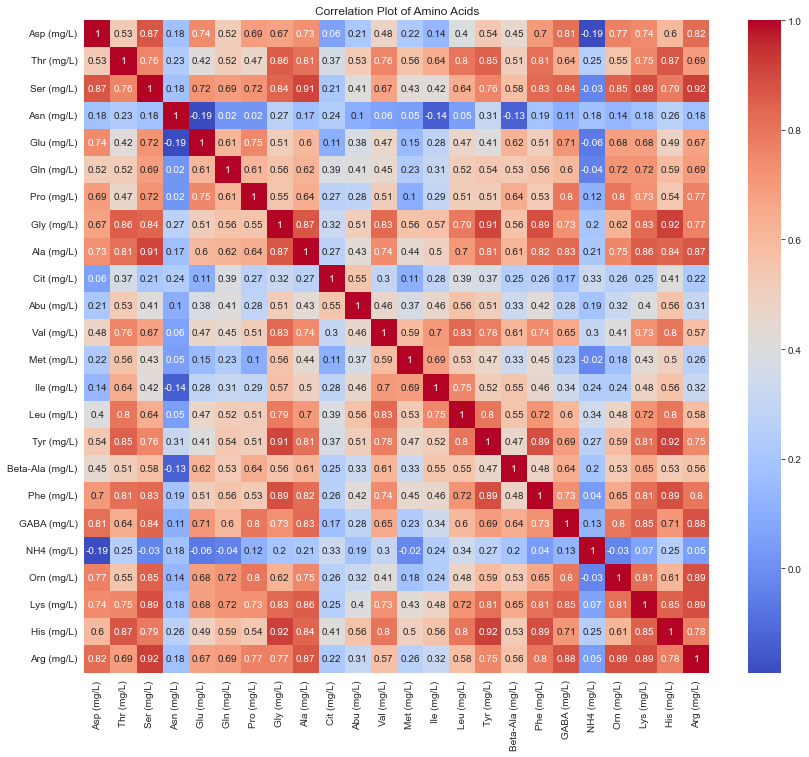

In [20]:
fig, ax = plt.subplots()

#Daten vorsortiren
cc = ac_data.loc[:,"Asp (mg/L)":]

#Korrelationsmatrix
cc = cc.corr(method = "spearman").round(decimals = 2)

#Visuelle Einstellungen

color_palette = sns.color_palette("coolwarm", as_cmap = True)
plt.title("Correlation Plot of Amino Acids")

#Plotten
fig.set_size_inches([14,12])
sns.heatmap(cc, annot = True, cmap=color_palette)


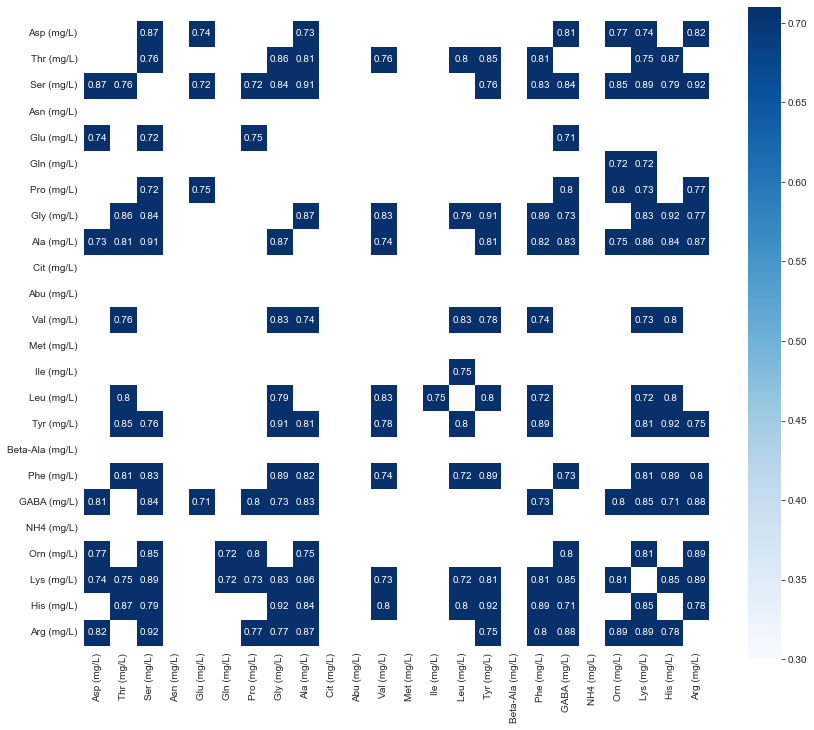

In [21]:
#Farbpalette aufsetzen
s = sns.color_palette("Blues", as_cmap=True)

#größte Korrelationen finden, da keine Pearson-Korrelation =1 beträgt, kann 1 logisch entfernt werden
filtered = cc[(cc > 0.7) & (cc != 1)]

#Plotten
f, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(filtered, annot= True, vmax=.3, square=True, cmap = s)

In [22]:
#Finding Highest Correlation of each Aminoacid
cc = cc[cc!=1]
highest_corr = []
for label, row in cc.iterrows():
    aminoacid_high_corr = []
    aminoacid_high_corr.append(label[:3])
    
    #find local max
    index_max = np.argmax(row)
    label_max = cc.columns[index_max]
    aminoacid_high_corr.append(label_max[:3])

    actual_rowmax = row[index_max]
    aminoacid_high_corr.append(actual_rowmax)


    highest_corr.append(aminoacid_high_corr)
highest_corr = pd.DataFrame(highest_corr)
column_names = ["AminoAcid1", "Aminoacid2", "Spearman-Correlation"]
highest_corr.columns = column_names
highest_corr[highest_corr["Spearman-Correlation"] > 0.8].sort_values("Spearman-Correlation", ascending = False)



,AminoAcid1,Aminoacid2,Spearman-Correlation
2,Ser,Arg,0.92
7,Gly,His,0.92
15,Tyr,His,0.92
22,His,Gly,0.92
23,Arg,Ser,0.92
8,Ala,Ser,0.91
17,Phe,Gly,0.89
20,Orn,Arg,0.89
21,Lys,Ser,0.89
18,GAB,Arg,0.88


<h3>Bonusfrage</h3>

<p>Die Korrelationen wurden auf eine Dezimalstelle gerundet, der Übersicht wegen. Man kann die jeweilige Korrelation der Aminosäuren untereinander an der Heatmap ablesen. 
Zum Beispiel korreliert Asp stark mit Ser, GABA, Orn und Arg, wohingegen Tyr mit Thr, Ser, Gly, Ala, Val, Leu, Phe, Lys, His und Arg korreliert. Die jeweils stärksten Korrelationen der Aminosäuren wurden im obigen DataFrame nochmal gesondert dargestellt.</p> 

<a href = "#1">Link back to top</a>
<hr>
<h2 id = "8" >Ausreißer</h2>

1.8481545038127558

10.762301406552755

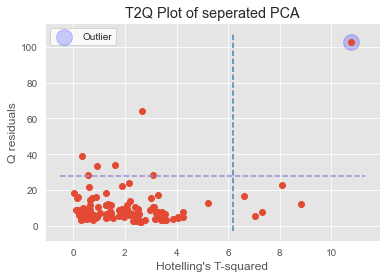

In [23]:
fig2, Q_orange, Tsq_orange = Tsq_Q_plot(X_orange_scaled, scores_orange[:,:2], loadings_orange[:,:2], conf=0.95, title = "T2Q Plot of seperated PCA")
plt.scatter(Tsq_orange.max(), Q_orange.max(), color = "blue", s = 250, alpha = 0.2, label="Outlier")
plt.legend() 
display(np.std(Tsq_orange))
np.argmax(Tsq_orange)
Tsq_orange.max()

In [24]:
#Was sind ist der immense Ausreißer?
display(np.argmax(Tsq_orange))
display(np.argmax(Q_orange))

#Gibt indeces des jeweils höchsten Wertes zurück:

43

43

In [25]:
grouped = orange_only.groupby("Fruit Type").mean()
grouped = grouped.loc["orange juice",:]


In [26]:
outlier = ac_data.iloc[[43], 5:].T
outlier["Av_orange_juice"] = grouped
outlier

Sample ID,16-30952,Av_orange_juice
Asp (mg/L),144.13,276.304889
Thr (mg/L),13.08,17.875111
Ser (mg/L),78.32,147.440889
Asn (mg/L),112.15,457.537444
Glu (mg/L),89.33,109.256111
Gln (mg/L),4.87,19.595778
Pro (mg/L),427.68,828.697222
Gly (mg/L),8.80,13.975556
Ala (mg/L),45.58,90.221667
Cit (mg/L),0.00,1.428000


<p>Probe 16-30952 hat verglichen mit den anderen Orangensäften viel zu niedere Werte an Arg, Asp, Ser, Asn. Oftmals hat es gerade einmal die Hälfte des Durchschnitt-Gehaltes. Dazu kommen weitere Abweichungen. Es ist klar zu sehen, dass diese Probe aus dem Modell fällt und ein Ausreißer ist. Möglicherweise wurde der Saft auch im Vorhinnein vom Hersteller verdünnt.</p>